### Importación Librerías

In [ ]:
!pip install skforecast
!pip install skforecast[full]
!pip install pandas_datareader
!pip install yfinance

In [1]:
# Manipulación datos:
import numpy as np
import pandas as pd

from numpy import array
#from keras.models import Sequential
#from keras.layers import Dense
from numpy import asarray
from pandas import DataFrame
from pandas import concat

# Gráficos
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from matplotlib import pyplot
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
%matplotlib inline

# Modelación y pronóstico
#Random Forest:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
##Regressor:
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.utils import save_forecaster
from skforecast.utils import load_forecaster

from joblib import dump, load


from datetime import datetime
from math import sqrt
# Configuración de warnings:
import warnings
warnings.filterwarnings('once')

In [4]:
#Estas son paqueterías complementarias para la descarga de datos financieros
import pandas
from pandas_datareader import data as pdr
import yfinance as yfin
yfin.pdr_override()
#Diable the warnings
import warnings
warnings.filterwarnings('ignore')

c:\Users\csake\anaconda3\lib\site-packages\pandas_datareader\compat\__init__.py:11: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  PANDAS_VERSION = LooseVersion(pd.__version__)


In [12]:
#Establecemos las fechas de consulta:
start = '2016-05-01'
end = '2018-01-28'

ticker = 'META'
data = pdr.get_data_yahoo(ticker, start, end)['Close']

[*********************100%%**********************]  1 of 1 completed


In [13]:
dt= pandas.DataFrame(data)
df= dt.rename(columns={'Close': 'y'})
df.info()
df.head(3)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 439 entries, 2016-05-02 to 2018-01-26
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   y       439 non-null    float64
dtypes: float64(1)
memory usage: 6.9 KB


,y
Date,
2016-05-02,118.570000
2016-05-03,117.430000
2016-05-04,118.059998


In [16]:
df.shape

(439, 1)

### Preprocesamiento de datos

In [17]:
dataindex= pd.to_datetime(df.index)
list(dataindex)

[Timestamp('2016-05-02 00:00:00'),
 Timestamp('2016-05-03 00:00:00'),
 Timestamp('2016-05-04 00:00:00'),
 Timestamp('2016-05-05 00:00:00'),
 Timestamp('2016-05-06 00:00:00'),
 Timestamp('2016-05-09 00:00:00'),
 Timestamp('2016-05-10 00:00:00'),
 Timestamp('2016-05-11 00:00:00'),
 Timestamp('2016-05-12 00:00:00'),
 Timestamp('2016-05-13 00:00:00'),
 Timestamp('2016-05-16 00:00:00'),
 Timestamp('2016-05-17 00:00:00'),
 Timestamp('2016-05-18 00:00:00'),
 Timestamp('2016-05-19 00:00:00'),
 Timestamp('2016-05-20 00:00:00'),
 Timestamp('2016-05-23 00:00:00'),
 Timestamp('2016-05-24 00:00:00'),
 Timestamp('2016-05-25 00:00:00'),
 Timestamp('2016-05-26 00:00:00'),
 Timestamp('2016-05-27 00:00:00'),
 Timestamp('2016-05-31 00:00:00'),
 Timestamp('2016-06-01 00:00:00'),
 Timestamp('2016-06-02 00:00:00'),
 Timestamp('2016-06-03 00:00:00'),
 Timestamp('2016-06-06 00:00:00'),
 Timestamp('2016-06-07 00:00:00'),
 Timestamp('2016-06-08 00:00:00'),
 Timestamp('2016-06-09 00:00:00'),
 Timestamp('2016-06-

In [18]:
# Damos formato de fecha con periodiciadad diaria a la serie.
df['Date'] = pd.to_datetime(df.index, format='%Y-%m-%d')  
#df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')  
df = df.set_index('Date')
df = df.asfreq('B')
df = df.sort_index()
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 455 entries, 2016-05-02 to 2018-01-26
Freq: B
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   y       439 non-null    float64
dtypes: float64(1)
memory usage: 7.1 KB


In [19]:
## Imputamos algún valor faltante con el valor anterior.
df.fillna(method='bfill', inplace=True)
print(f'Number of rows with missing values: {df.isnull().any(axis=1).mean()}')

Number of rows with missing values: 0.0


<a id="6"></a> <br>
### 4. Partición de datos en entrenamiento y prueba

En esta seción, partimos el conjunto de datos de pueba y de entrenamiento. 

In [22]:
df.shape[0]*0.05

22.75

In [23]:
# Split data into train-test
# ==============================================================================
steps = 23
data_train = df[:-steps]
data_test  = df[-steps:]
print(f"Train dates : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Test dates  : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

#Así también para las fechas:
date_train = dataindex[:-steps]
date_test = dataindex[-steps:]

Train dates : 2016-05-02 00:00:00 --- 2017-12-26 00:00:00  (n=432)
Test dates  : 2017-12-27 00:00:00 --- 2018-01-26 00:00:00  (n=23)


<a id="4"></a> <br>
### 5. Visualización de datos financieros

Para mirar la serie, debemos importar la librería de matplotlib.

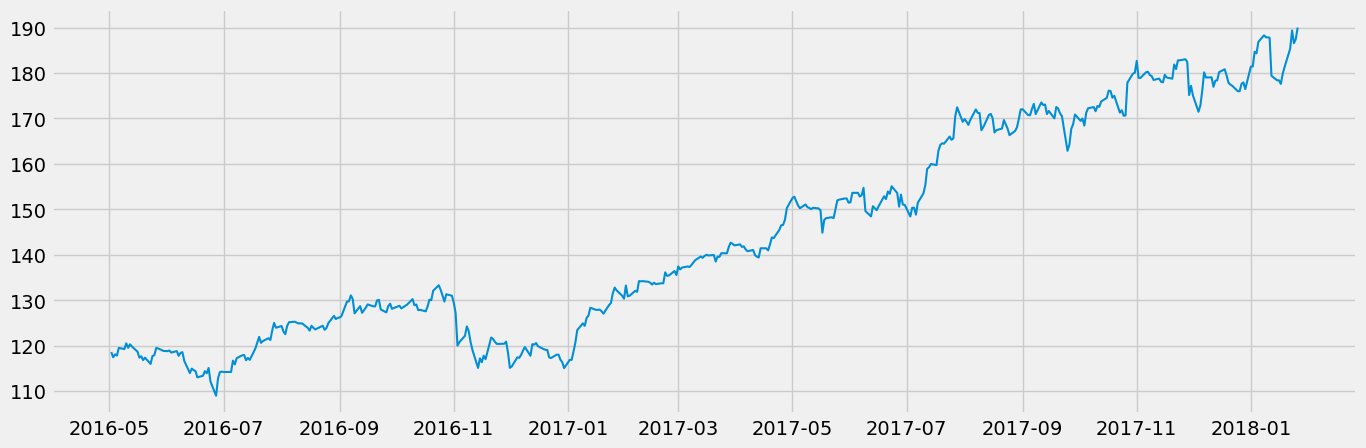

In [25]:
#Una vez llamada la librería, graficamos la serie dt.
import matplotlib.pyplot as plt
plt.figure(figsize=(15,5))
plt.plot(df)

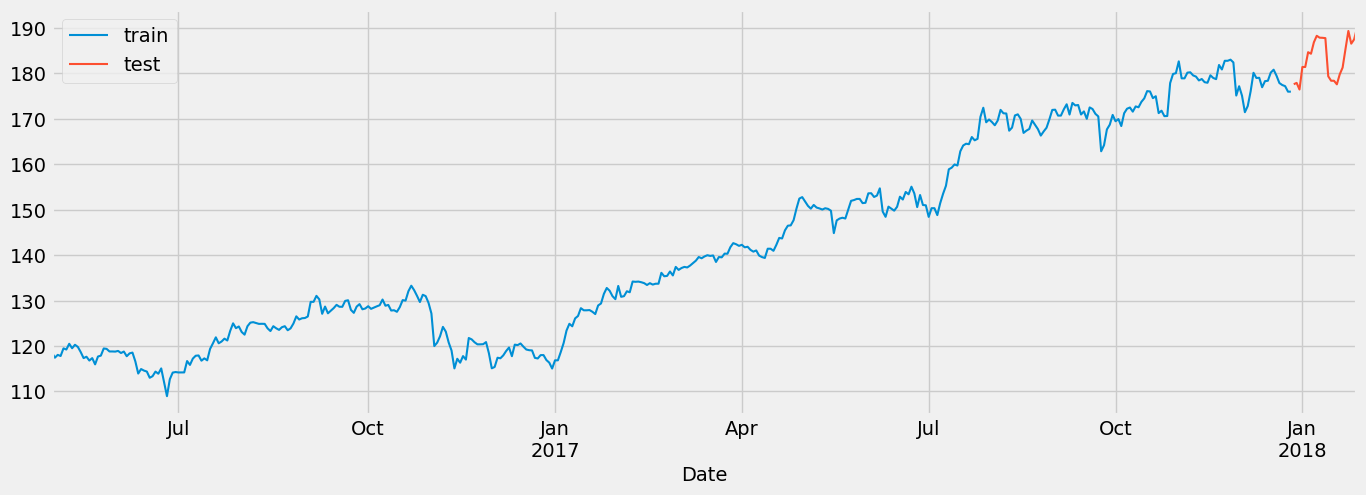

In [30]:

fig, ax = plt.subplots(figsize=(15, 5))

data_train['y'].plot(ax=ax, label='train')
data_test['y'].plot(ax=ax, label='test')
ax.legend();

In [32]:
#Otra opción, es emplear la librería de go.Scatter para otro tipo de gráfico. 
trace1 = go.Scatter(
    x = date_train,
    y = data_train['y'],
    mode = 'lines',
    name = 'Data'
)

trace2 = go.Scatter(
    x = date_test,
    y = data_test['y'],
    mode = 'lines',
    name = 'test'
)

layout = go.Layout(
    title = "Bond ",
    xaxis = {'title' : "Date"},
    yaxis = {'title' : "Close"}
)
fig = go.Figure(data=[trace1, trace2], layout=layout)
fig.show()

<a id="7a"></a> <br>
# 6. Regresión con Random Forest
En esta sección, comenzaremos la regresión empleando el algoritmo de Random Forest. Para ello, comenzaremos con la creación de la estructura de datos tipo aprendizaje supervisado. Esto se hace mediante la función de ForecasterAutoreg.

In [43]:
Lag_seleccionado = 15

In [44]:
# Creamos y entrenamos el modelo de Random Forest con la función de estructura de datos generada a través de la función Forecaster, en este caso, creando ventanas de 10 días:
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags = Lag_seleccionado
                )

forecaster.fit(y=data_train['y'])
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15] 
Transformer for y: None 
Transformer for exog: None 
Window size: 15 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2016-05-02 00:00:00'), Timestamp('2017-12-26 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: B 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
fit_kwargs: {} 
Creation date: 2024-05-11 11:30:41 
Last fit date: 2024-05-11 11:30:41 
Skforecast 

In [45]:
steps = 23  ## el mismo que la ventana de test
predictions = forecaster.predict(steps=steps)
predictions.head(5)

2017-12-27    176.954602
2017-12-28    178.113601
2017-12-29    179.110700
2018-01-01    179.503900
2018-01-02    179.497699
Freq: B, Name: pred, dtype: float64

In [46]:
# Determinamos el error de pronóstico:
# ==============================================================================
from sklearn.metrics import mean_absolute_error


error_mse = mean_squared_error(
                y_true = data_test['y'],
                y_pred = predictions
            )

def error_mape(y_true,y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true))

mae = mean_absolute_error(y_true=data_test['y'], y_pred=predictions)
mape = error_mape(y_true=data_test['y'], y_pred=predictions)

print("Mean Absolute Error:", mae)
print("MAPE:", mape)

print(f"Test error (mse): {error_mse}")
RMSE = sqrt(error_mse)
print(f"Test error (rmse): {RMSE}")

Mean Absolute Error: 4.595855354640797
MAPE: 0.024652328699949922
Test error (mse): 33.27862701005425
Test error (rmse): 5.768763039859953


LSTM